In [ ]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Get Data

out dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class ( 750 training, 250 testing)

our subset of the data starts with 3 classes of food and only 10% of the images ( ~75 training, 25 testing).

We are starting our ML project with small scall of the dataset then we will increase the scale when necessary.

The Important thing is to speed up how fast you can experiment

## 1.1 Download the data from any URL to google colab

In [ ]:
import requests
import zipfile
from pathlib import Path

# setup path to data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# if the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download')
else:
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True,exist_ok=True)

with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print('Downloading pizza, steak and sushi data...')
  f.write(request.content)

# unzip the file
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping pizza, steak and sushi data...')
  # here we have to files 1) the downloaded 'pizza_steak_sushi.zip'
  # and we have 2) the image_path 'pizza_steak_sushi'
  # we will extract every thing from the downloaded file 'pizza_steak_sushi.zip'
  # and then write it's content to the image_path file
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


# 2. Becoming one with the data (data preparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path and print its contents"""
  for dirpath,dirnames, filenames in os.walk(dir_path) :
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [ ]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizing an image

1. Get all of the image paths
2. Pick a random image path unsig python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're woriking with images, let's open the image with Python PIL
5. We'll then show the image and print metadata

radnom image path: data/pizza_steak_sushi/train/pizza/1524655.jpg
random image class: pizza
random image height: 512
random image width: 512


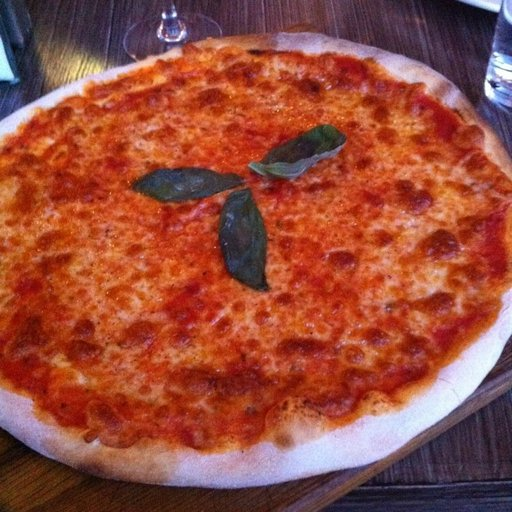

In [ ]:
import random
from PIL import Image



# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. pick a radnom image path
random_image_path = random.choice(image_path_list)


# 3. Get image class from path name
image_class = random_image_path.parent.stem


# 4. Open image
img = Image.open(random_image_path)

# 5. print metadata
print(f'radnom image path: {random_image_path}')
print(f'random image class: {image_class}')
print(f'random image height: {img.height}')
print(f'random image width: {img.width}')
img

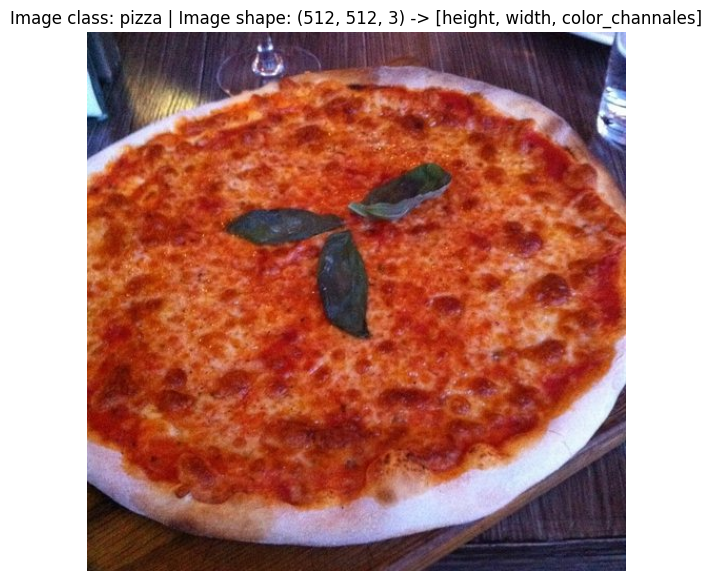

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into numpy array
img_as_array = np.asarray(img)

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channales]')
plt.axis(False);
plt.show()

# 3. Transforming data

1. Turn your target into tensors.
2. Turn it into `torch.utils.data.Dataset`
3. Turn it into `torch.utils.data.DataLoader`

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

## 3.1 Transforming data with `torchvision.transforms`

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # resize the data into 64x64
    transforms.Resize(size=(64,64)),
    # Flit the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into torch.Tensor
    transforms.ToTensor()
])

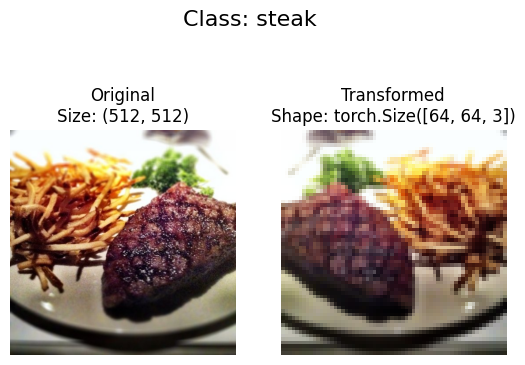

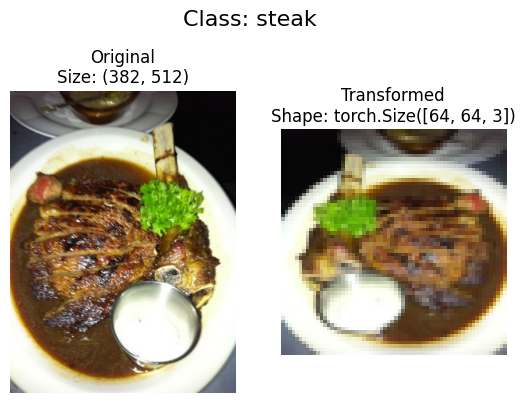

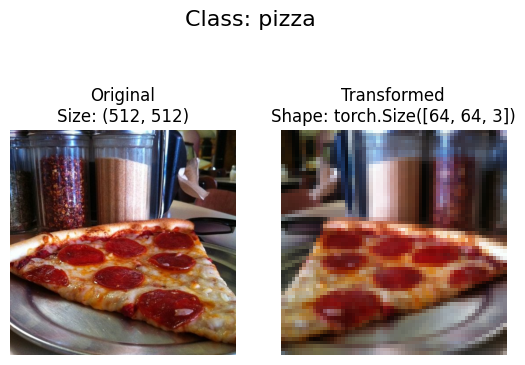

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  # set the random seed
  if seed:
    random.seed(seed)
  # pcik random n images from the image paths list
  random_image_paths = random.sample(image_paths, k=n)
  # iterate over all images
  for image_path in random_image_paths:
    # open the images using PIL.Image.open
    with Image.open(image_path) as f:
      # set a figure and axis
      fig, ax = plt.subplots(nrows=1, ncols=2)
      # plot the original image
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # Transform and plot the image
      transformed_image = transform(f).permute(1,2,0) # change [C,H,W] -> [H,W,C] to plot
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_path_list, data_transform, 3)


# 4. Option 1: Loading image data using `ImageFolder`

In [ ]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for the data
                                  target_transform=None)    # transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
len(train_data), len(test_data)

(225, 75)

In [ ]:
img, label = train_data[0]
print(f"Image shape: {img.shape}")
print(f'Image datatype: {img.dtype}')
print(f'Image label: {class_names[label]}')
print(f'Label datatype: {type(label)}')

Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: pizza
Label datatype: <class 'int'>


In [ ]:
# creating a data loaders for training and testing
EPOCHS = 10
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers=2)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False,
                             num_workers=2)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c85d88fbe90>,
 <torch.utils.data.dataloader.DataLoader at 0x7c85d88d3ed0>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(15, 5)

In [ ]:
img, label = next(iter(train_dataloader))
print(f'Image shpae: {img.shape}') # 16 examples of [3,64,64] Pictures
print(f"Label shape: {label.shape}") # 16 labels for each pircture

Image shpae: torch.Size([16, 3, 64, 64])
Label shape: torch.Size([16])


# 5. Option 2 :Loading Image Data with a custome `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names as list and dictionary from the dataset

Pros:
* Can create `Dataset` out of almost anyting
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work
* Using a custom class `Dataset` means more code, and this could lead to errors or performance issues


In [ ]:
import os
import pathlib
import torch
import numpy as np

from PIL import Image
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from typing import Tuple, Dict, List


In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.1 Create a helper function to get the class names

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f'Target Directory: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str|Path) -> Tuple[List[str], Dict[str,int]] :
  """Finds the class folder names in target directory"""
  # 1. Get the class names by scanning the target directory
  classes_list = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir)

  # 2. Raise an error if class names could not be found
  if not classes_list:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... Pleas ckeck file structure.")

  # 3. Create dictionary of index label
  classes_dict = {class_name: i for i, class_name in enumerate(classes_list)}

  return classes_list, classes_dict

In [ ]:
class_names, class_to_idx = find_classes(target_directory)
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.2 Create a custome `Dataset` to replicate `ImageFolder`

In [ ]:
# Write a custom dataset
from torch.utils.data import Dataset

# 1. Subclass Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom datset
  def __init__(self, targ_dir: str|Path, transform=None):
    # 3. create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # Setup transform
    self.transform = transform
    # create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """Opens an image via path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. overwrite __len__()
  def __len__(self) -> int:
    return len(self.paths)

  # overwrite __getitem__()
  def __getitem__(self, index: int) :
    """Returns one sample of the data (X,y)"""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                    transform=test_transform)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7c85d8905a50>,
 <__main__.ImageFolderCustom at 0x7c85d8876410>)

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
len(test_data), len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers=2,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers =2,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c8602033910>,
 <torch.utils.data.dataloader.DataLoader at 0x7c85d8af0fd0>)

In [ ]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

# 6. prepare the data and train a baseline model

## 6.1 preparing the data

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets,transforms
import os
# Setup HyperParameters
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()
EPOCHS = 25
# create a transform
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
# load the data from the Folders to pytorch data set
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
# create data loaders to train the model
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers=NUM_WORKERS)
len(test_dataloader), len(train_dataloader)

(5, 15)

## 6.2 Creating a baseline model

In [ ]:
from torch import nn
class CnnModelV0(nn.Module):
  def __init__(self,
               input_channels: int,
               hiddin_layers: int,
               output_classes: int):
    super().__init__()
    # the input Image should be 64x64x3
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels= input_channels,
                  out_channels=hiddin_layers,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hiddin_layers,
                  out_channels=hiddin_layers,
                  kernel_size = 3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride= 2)
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=hiddin_layers,
                  out_channels=hiddin_layers,
                  kernel_size = 3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hiddin_layers,
                  out_channels=hiddin_layers,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hiddin_layers * 16 * 16,
                  out_features = output_classes)
    )

  def forward(self, x) :
    return self.classifier(self.conv_layer2(self.conv_layer1(x)))

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = CnnModelV0(input_channels=3, # number of color channels
                     hiddin_layers=16,
                     output_classes = len(train_data.classes)# number of output classes
                     ).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params = model_0.parameters(), lr=0.001)

In [ ]:
try:
  import torchinfo
except :
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
CnnModelV0                               [1, 3]                    --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           448
│    └─ReLU: 2-2                         [1, 16, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 16, 64, 64]           2,320
│    └─ReLU: 2-4                         [1, 16, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 16, 32, 32]           --
├─Sequential: 1-2                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 16, 32, 32]           2,320
│    └─ReLU: 2-7                         [1, 16, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 16, 32, 32]           2,320
│    └─ReLU: 2-9                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 16, 16, 16]           --
├─Seq

## 6.3 Building the tarining and testing loop

In [ ]:
from tqdm.auto import tqdm
from typing import Callable
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt


def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def fit_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn: Callable[[torch.Tensor, torch.Tensor], float],
    device = torch.device('cpu'),
    epochs : int = 10,
    print_values :bool = True,
    plot_loss: bool = True
):
  """
  This function is going to train the model on the givin train_loader, calculate the loss and optimize the parameters,
  optional : can print the values of the loss and accuracy

  Args:
  model: a troch.nn.Module model to be traind * this only works for class models not predifined models *
  train_loader: a troch.utils.data.DataLoader to train and fit the module on
  test_loader: a torch.utils.data.DataLoader to test the accuracy and the performanse of the mdoule
  loss_fn: measures how wrong the model is perfoming on the givin data
  optimizer: torch.optim.Opimizer to update the paramters of the model to reduce the loss_fn
  accuracy_fn: *Optional* python function to calculate the error of the model with parameters (y_true,y_pred)
  device: *Optional* set the device to 'cpu' or 'cuda'default is 'cpu
  epcohs: *Optional* the number of outer loop 'epochs' how many iterations on the whole data set, defualt is 10
  print_values: *Optional* wither to print the values of the loss and error or not, default is True
  plot_loss : *Optional* plot line curves of the train and test loss behavior
  """

  model.train()
  train_losses = []
  test_losses = []

  for epoch in tqdm(range(epochs), desc='Training and Testing progress: '):

    print(f"Epoch: {epoch}\n----------")
    train_loss,train_acc = 0,0
    ### Training loop
    for batch, (X,y) in tqdm(enumerate(train_loader), desc='Number of examples: '):
      # moveing the data to the target device
      X,y = X.to(device), y.to(device)

      # make predections *Forward pass*
      y_logits = model(X)

      # calculate the loss and accuracy
      loss = loss_fn(y_logits,y)
      train_acc += accuracy_fn(y,y_logits.argmax(dim=1))
      train_loss += loss.item()

      # optimizer zero grad
      optimizer.zero_grad()
      # loss backward *Backpropagation*
      loss.backward()
      # optimizer step
      optimizer.step()


    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    ### Testing
    test_loss, test_acc = 0,0
    model.eval()
    with torch.inference_mode():
      for X_test,y_test in test_loader:
        X_test,y_test = X_test.to(device), y_test.to(device)
        y_test_logits = model(X_test)

        loss_test = loss_fn(y_test_logits, y_test)

        test_loss += loss_test.item()
        test_acc += accuracy_fn(y_test, y_test_logits.argmax(dim=1))

      test_loss /= len(test_loader)
      test_acc /= len(test_loader)

      train_losses.append(train_loss)
      test_losses.append(test_loss)

    if print_values:
      print(f"Epoch: {epoch+1} | Train Loss {train_loss:.4f} | Train accuracy: {train_acc:.4f}% | Test Loss {test_loss:.4f} | Test accuracy: {test_acc:.4f}%\n")

  if plot_loss:
    plt.figure(figsize=(8,8))
    plt.plot(range(epochs), train_losses, color='blue',label='train loss')
    plt.plot(range(epochs), test_losses, color='green', label='test loss')
    plt.title('Train and Test Loss curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Training and Testing progress:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 0
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 1 | Train Loss 1.1082 | Train accuracy: 31.2500% | Test Loss 1.0972 | Test accuracy: 29.3182%

Epoch: 1
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 2 | Train Loss 1.0841 | Train accuracy: 42.9167% | Test Loss 1.0795 | Test accuracy: 52.0455%

Epoch: 2
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 3 | Train Loss 1.0011 | Train accuracy: 50.4167% | Test Loss 1.0423 | Test accuracy: 47.0455%

Epoch: 3
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 4 | Train Loss 0.9089 | Train accuracy: 52.9167% | Test Loss 0.9972 | Test accuracy: 49.7727%

Epoch: 4
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 5 | Train Loss 0.9008 | Train accuracy: 62.9167% | Test Loss 1.0074 | Test accuracy: 46.0227%

Epoch: 5
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 6 | Train Loss 0.8629 | Train accuracy: 63.7500% | Test Loss 1.0478 | Test accuracy: 44.7727%

Epoch: 6
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 7 | Train Loss 0.8216 | Train accuracy: 64.1667% | Test Loss 1.0292 | Test accuracy: 44.7727%

Epoch: 7
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 8 | Train Loss 0.7841 | Train accuracy: 65.4167% | Test Loss 1.0612 | Test accuracy: 46.5909%

Epoch: 8
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 9 | Train Loss 0.9136 | Train accuracy: 58.7500% | Test Loss 0.9978 | Test accuracy: 38.6364%

Epoch: 9
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 10 | Train Loss 0.8889 | Train accuracy: 59.5833% | Test Loss 0.9966 | Test accuracy: 48.8636%

Epoch: 10
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 11 | Train Loss 0.8263 | Train accuracy: 59.1667% | Test Loss 1.1379 | Test accuracy: 42.3864%

Epoch: 11
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 12 | Train Loss 0.7807 | Train accuracy: 62.9167% | Test Loss 1.1160 | Test accuracy: 49.7727%

Epoch: 12
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 13 | Train Loss 0.7652 | Train accuracy: 69.5833% | Test Loss 1.0311 | Test accuracy: 46.8182%

Epoch: 13
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 14 | Train Loss 0.7505 | Train accuracy: 65.4167% | Test Loss 1.0535 | Test accuracy: 45.4545%

Epoch: 14
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 15 | Train Loss 0.6778 | Train accuracy: 72.5000% | Test Loss 1.0914 | Test accuracy: 44.2045%

Epoch: 15
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 16 | Train Loss 0.7155 | Train accuracy: 64.5833% | Test Loss 1.0759 | Test accuracy: 51.5909%

Epoch: 16
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 17 | Train Loss 0.6437 | Train accuracy: 73.3333% | Test Loss 1.0224 | Test accuracy: 51.5909%

Epoch: 17
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 18 | Train Loss 0.6326 | Train accuracy: 72.9167% | Test Loss 1.0641 | Test accuracy: 50.4545%

Epoch: 18
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 19 | Train Loss 0.6040 | Train accuracy: 77.0833% | Test Loss 1.0117 | Test accuracy: 56.4773%

Epoch: 19
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 20 | Train Loss 0.5872 | Train accuracy: 74.5833% | Test Loss 1.1817 | Test accuracy: 54.5455%

Epoch: 20
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 21 | Train Loss 0.7875 | Train accuracy: 66.6667% | Test Loss 1.0719 | Test accuracy: 48.6364%

Epoch: 21
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 22 | Train Loss 0.7456 | Train accuracy: 64.5833% | Test Loss 1.0921 | Test accuracy: 46.8182%

Epoch: 22
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 23 | Train Loss 0.6957 | Train accuracy: 69.5833% | Test Loss 1.0519 | Test accuracy: 47.2727%

Epoch: 23
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 24 | Train Loss 0.6310 | Train accuracy: 68.3333% | Test Loss 1.0802 | Test accuracy: 50.4545%

Epoch: 24
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 25 | Train Loss 0.4903 | Train accuracy: 80.4167% | Test Loss 1.0871 | Test accuracy: 52.2727%

Epoch: 25
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 26 | Train Loss 0.5127 | Train accuracy: 77.0833% | Test Loss 1.1658 | Test accuracy: 53.5227%

Epoch: 26
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 27 | Train Loss 0.5045 | Train accuracy: 79.1667% | Test Loss 1.3122 | Test accuracy: 45.5682%

Epoch: 27
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 28 | Train Loss 0.5191 | Train accuracy: 79.1667% | Test Loss 1.2693 | Test accuracy: 49.6591%

Epoch: 28
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 29 | Train Loss 0.4274 | Train accuracy: 83.3333% | Test Loss 1.2598 | Test accuracy: 48.5227%

Epoch: 29
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 30 | Train Loss 0.3480 | Train accuracy: 88.3333% | Test Loss 1.2878 | Test accuracy: 53.5227%

Epoch: 30
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 31 | Train Loss 0.3110 | Train accuracy: 88.3333% | Test Loss 1.6414 | Test accuracy: 46.1364%

Epoch: 31
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 32 | Train Loss 0.3054 | Train accuracy: 85.8333% | Test Loss 1.4684 | Test accuracy: 52.8409%

Epoch: 32
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 33 | Train Loss 0.2779 | Train accuracy: 90.8333% | Test Loss 1.7920 | Test accuracy: 52.2727%

Epoch: 33
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 34 | Train Loss 0.3014 | Train accuracy: 87.9167% | Test Loss 1.6588 | Test accuracy: 50.4545%

Epoch: 34
----------


Number of examples: : 0it [00:00, ?it/s]

Epoch: 35 | Train Loss 0.2486 | Train accuracy: 92.5000% | Test Loss 1.8112 | Test accuracy: 50.4545%



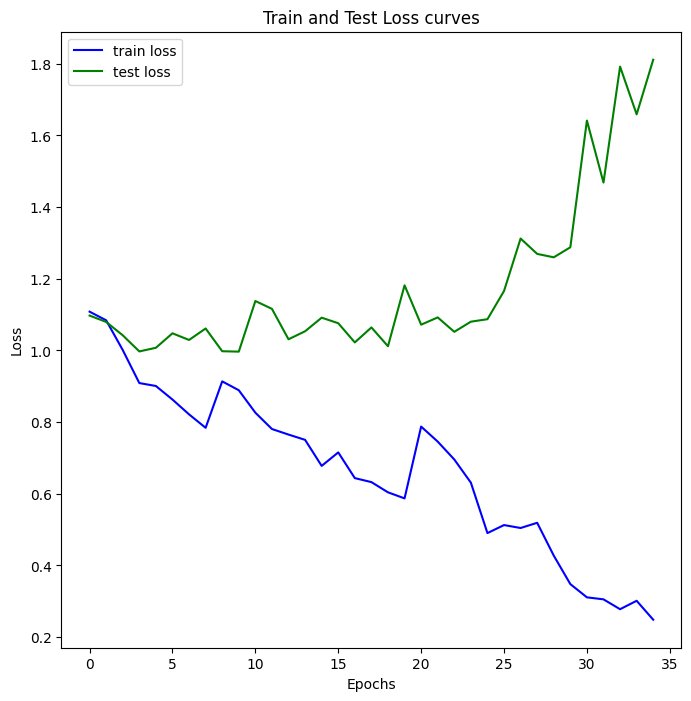

In [ ]:
fit_model(
    model_0,
    train_dataloader,
    test_dataloader,
    loss_fn = loss_fn,
    optimizer=optimizer,
    accuracy_fn = accuracy_fn,
    epochs = 35,
    device = device,
    print_values=True,
    plot_loss = True
)